## Importing Required Libraries

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.cm as cm 

## Define Constants
Here, we define constants like image size, batch size, number of epochs, and dataset directories.

In [2]:
# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 5 
TRAIN_DIR = 'dataset/training_set/'
VALID_DIR = 'dataset/validation_set/'

## Model Creation
We use MobileNetV2 as the base model and freeze its layers to retain the pre-trained weights. We then add custom layers on top of it for classification.

In [3]:
# Create the model
def create_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

## Custom Data Generator
We define a custom image data generator class, `RobustImageDataGenerator`, to load, preprocess, and batch images from the dataset directories. The generator supports categorical and binary class modes and can shuffle the data after each epoch.

In [4]:
# Custom data generator
class RobustImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, batch_size, target_size, class_mode='categorical', shuffle=True):
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.class_mode = class_mode
        self.shuffle = shuffle
        
        self.classes = sorted(os.listdir(directory))
        self.class_indices = {cls: i for i, cls in enumerate(self.classes)}
        self.filenames = self._get_filenames()
        self.num_classes = len(self.classes)
        
        self.on_epoch_end()
    
    def _get_filenames(self):
        filenames = []
        for class_name in self.classes:
            class_dir = os.path.join(self.directory, class_name)
            for filename in os.listdir(class_dir):
                filenames.append((class_name, filename))
        return filenames
    
    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_filenames = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = []
        batch_y = []
        
        for class_name, filename in batch_filenames:
            try:
                img_path = os.path.join(self.directory, class_name, filename)
                img = load_img(img_path, target_size=self.target_size)
                img_array = img_to_array(img)
                img_array = img_array / 255.0  # Normalize
                batch_x.append(img_array)
                
                if self.class_mode == 'categorical':
                    y = np.zeros(self.num_classes)
                    y[self.class_indices[class_name]] = 1
                elif self.class_mode == 'binary':
                    y = self.class_indices[class_name]
                batch_y.append(y)
            except Exception as e:
                print(f"Error loading image {filename}: {str(e)}")
                continue
        
        return np.array(batch_x), np.array(batch_y)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.filenames)

## Data Generator Creation
We now create training and validation data generators using the `RobustImageDataGenerator` class.

In [5]:
# Create data generators
def create_data_generators():
    train_generator = RobustImageDataGenerator(
        TRAIN_DIR,
        batch_size=BATCH_SIZE,
        target_size=IMG_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    valid_generator = RobustImageDataGenerator(
        VALID_DIR,
        batch_size=BATCH_SIZE,
        target_size=IMG_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    print(f"Found {len(train_generator.filenames)} images for training")
    print(f"Found {len(valid_generator.filenames)} images for validation")
    
    return train_generator, valid_generator

## Model Training
The model is compiled and trained using the Adam optimizer, with categorical cross-entropy as the loss function. We also implement early stopping and learning rate reduction callbacks to prevent overfitting.

In [6]:
# Training process
def train_model():
    model = create_model()
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    train_generator, valid_generator = create_data_generators()
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6
    )
    
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=valid_generator,
        callbacks=[early_stopping, reduce_lr]
    )
    
    return model, history

## Training History Plotting
Once the model is trained, we plot the training and validation accuracy and loss to visualize the model's performance over the epochs.

In [7]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Display Grayscale and Colorized Image
After training the model, we display a sample grayscale image along with its colorized version to visualize the result of the learning.

In [8]:
# Function to display a grayscale image and its colorized version after training
def display_grayscale_and_colorized_image(model):
    # Load a sample image from the training directory
    sample_class = os.listdir(TRAIN_DIR)[0]
    sample_image_path = os.path.join(TRAIN_DIR, sample_class, os.listdir(os.path.join(TRAIN_DIR, sample_class))[0])
    
    # Load and process the image
    img = load_img(sample_image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0  # Normalize the image
    
    # Convert the image to grayscale
    grayscale_img = cv2.cvtColor((img_array * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    
    # Apply a color map to simulate colorization (e.g., using a 'jet' colormap)
    colorized_img = cm.jet(grayscale_img / 255.0)[:, :, :3]  # Applying a colormap
    
    # Display both grayscale and colorized images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(grayscale_img, cmap='gray')
    plt.title("Grayscale Image After Training")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(colorized_img)
    plt.title("Colorized Image After Training")
    plt.axis('off')

    plt.show()

## Start Training
Now, we start the training process and visualize the results once the training is complete.

In [9]:
# Start training
print("Starting the training process...")
trained_model, training_history = train_model()

Starting the training process...
Found 7819 images for training
Found 866 images for validation
Epoch 1/10
Error loading image 1500.jpg: cannot identify image file <_io.BytesIO object at 0x00000220E6456B30>
Error loading image 261.jpg: cannot identify image file <_io.BytesIO object at 0x00000220E6456B30>
 58/245 [======>.......................] - ETA: 29s - loss: 0.6371 - accuracy: 0.7837Error loading image 0125.jpg: cannot identify image file <_io.BytesIO object at 0x00000220E68B95E0>
Error loading image 0025.jpg: cannot identify image file <_io.BytesIO object at 0x00000220E68B9360>
 84/245 [=========>....................] - ETA: 25s - loss: 0.5260 - accuracy: 0.8183Error loading image 210.jpg: cannot identify image file <_io.BytesIO object at 0x00000220E68B9C20>
Error loading image 1125.jpg: cannot identify image file <_io.BytesIO object at 0x00000220E68B9E50>
105/245 [===========>..................] - ETA: 21s - loss: 0.4760 - accuracy: 0.8361Error loading image 1100.jpg: cannot ide

C:\Users\TSA\anaconda3\envs\tf\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Error loading image 0550.jpg: cannot identify image file <_io.BytesIO object at 0x00000220E68C8950>
175/245 [====================>.........] - ETA: 10s - loss: 0.3819 - accuracy: 0.8664Error loading image 1000.jpg: cannot identify image file <_io.BytesIO object at 0x00000220E68C8040>
Error loading image 356.jpg: cannot identify image file <_io.BytesIO object at 0x00000220E6A22B80>
197/245 [=======================>......] - ETA: 7s - loss: 0.3659 - accuracy: 0.8726Error loading image 1900.jpg: cannot identify image file <_io.BytesIO object at 0x00000220E6A228B0>
Error loading image 200.jpg: cannot identify image file <_io.BytesIO object at 0x00000220E6A228B0>
Error loading image 0925.jpg: cannot identify image file <_io.BytesIO object at 0x00000220E6A228B0>
228/245 [==========================>...] - ETA: 2s - loss: 0.3493 - accuracy: 0.8775Error loading image 0200.jpg: cannot identify image file <_io.BytesIO object at 0x00000220E6A264F0>
Error loading image 0000.jpg: cannot identify ima

## Save the Trained Model
After training, we save the model for future use.

In [10]:
# After training is complete, save the model
print("Training completed. Saving the model...")
trained_model.save('transfer_learning_model.h5')
print("Model saved successfully.")

Training completed. Saving the model...
Model saved successfully.


## Plot Training History
We plot the training history to visualize accuracy and loss trends.

Plotting training history...


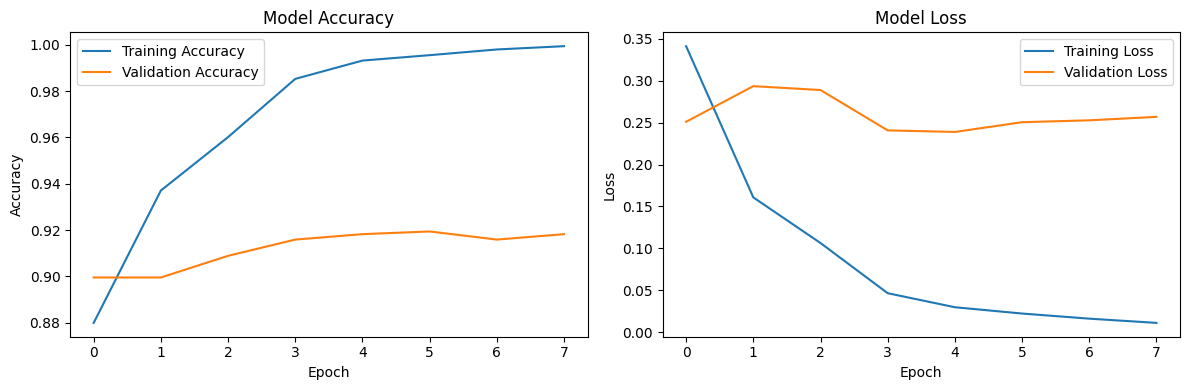

Training history plot displayed.


In [11]:
# Plot training history
print("Plotting training history...")
plot_training_history(training_history)
print("Training history plot displayed.")

# Display grayscale and colorized image after training

Displaying grayscale and colorized image after training...


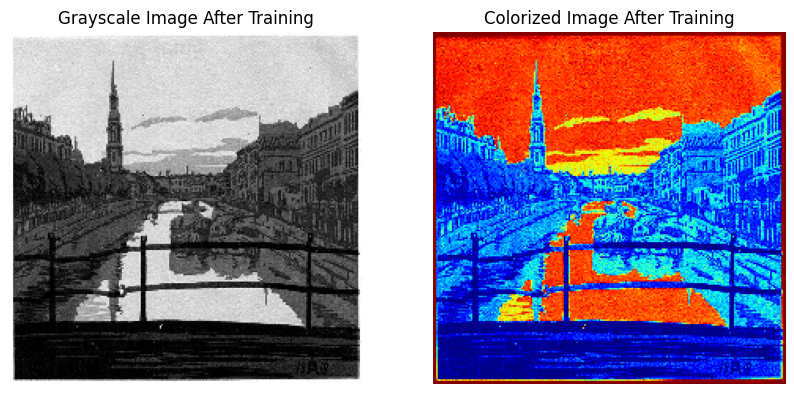

In [12]:
# Display grayscale and colorized image after training
print("Displaying grayscale and colorized image after training...")
display_grayscale_and_colorized_image(trained_model)